In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:50%]', 'test[:50%]'],
    shuffle_files=True,
    with_info=True)

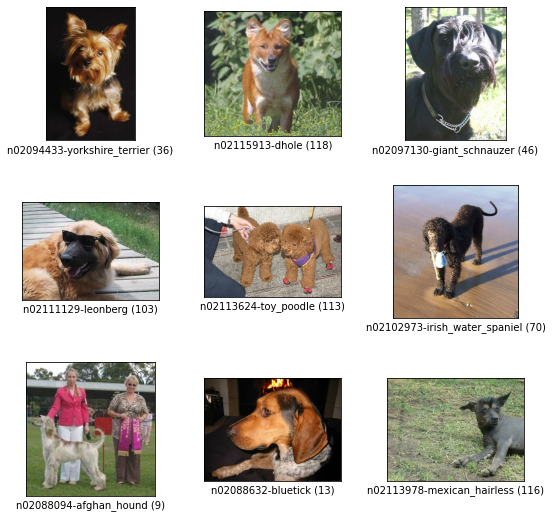

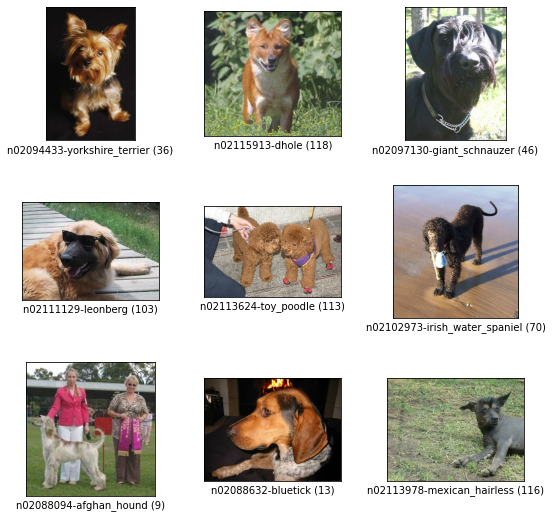

In [4]:
tfds.show_examples(ds_train, ds_info)

# CutMix

### 이미지 섞기

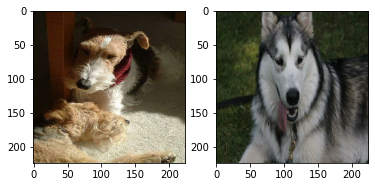

In [34]:
# 데이터셋에서 이미지 2개를 가져옵니다.
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_0 = image[0]
        image_1 = image[1]
        label_0 = label[0]
        label_1 = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_0)

plt.subplot(1,2,2)
plt.imshow(image_1)

In [35]:
def get_clip_box(image_0, image_1):
    # image.shape = (height, width, channel)
    image_size_x = image_0.shape[1]
    image_size_y = image_0.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_0, image_1)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(99, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(97, shape=(), dtype=int32)


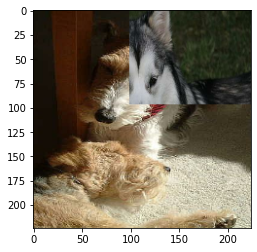

In [36]:
# 바탕이미지 image_0의 바탕영역을, 다른 이미지 image_1의 바운딩 박스 영역을 가져와서 합치는 함수
#min two images
def mix_2_images(image_0, image_1, x_min, y_min, x_max, y_max):
    image_size_x = image_0.shape[1]
    image_size_y = image_0.shape[0]
    
    # image_1의 왼쪽 바깥 영역
    middle_left = image_0[y_min:y_max, 0:x_min, :]
    # image_1의 안쪽 영역
    middle_center = image_1[y_min:y_max, x_min:x_max, :]
    # image_1의 오른족 바깥 영역
    middle_right = image_0[y_min:y_max, x_max:image_size_x, :]
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    top = image_0[0:y_min, :, :]
    bottom = image_0[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_0, image_1, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 라벨 섞기

In [7]:
# mix two labels
def mix_2_labels(image_0, label_0, label_1, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_0.shape[1]
    image_size_y = image_0.shape[0]
    mixed_area = (x_max-x_min) * (y_max-y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)
    
    if len(label_0.shape)==0:
        label_0 = tf.one_hot(label_0, num_classes)
    if len(label_1.shape)==0:
        label_1 = tf.one_hot(label_1, num_classes)
    mixed_label = (1-ratio) * label_0 + ratio * label_0
    return mixed_label

#mixed_label = mix_2_labels(label_0, label_1, x_min, y_min, x_max, y_max)
#mixed_label

In [8]:
# 배치단위 cutmix 함수 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_0 = image[i]
        label_0 = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_1 = image[j]
        label_1 = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_0, image_1)
        mixed_imgs.append(mix_2_images(image_0, image_1, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_0, label_0, label_1, x_min, y_min, x_max, y_max))
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Mixup

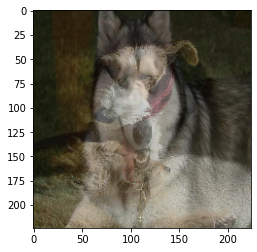

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.4612248 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.5387752 0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [37]:
# function for mixup
def mixup_2_images(image_0, image_1, label_0, label_1):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_0.shape)==0:
        label_0 = tf.one_hot(label_0, num_classes)
    if len(label_1.shape)==0:
        label_1 = tf.one_hot(label_1, num_classes)
    mixed_image = (1-ratio) * image_0 + ratio * image_1
    mixed_label = (1-ratio) * label_0 + ratio * label_1
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_0, image_1, label_0, label_1)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [10]:
# 배치단위 mixup 구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_0 = image[i]
        label_0 = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_1 = image[j]
        label_1 = label[j]
        mixed_img, mixed_label = mixup_2_images(image_0, image_1, label_0, label_1)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# CutMix 또는 Mixup 비교실험 하기

## 1. Augmentation을 적용한 데이터셋 만들기

In [11]:
def normalize_and_resize_img(image, label):
    # Normalizes images: 'uint8' -> 'float32'
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    # 반전
    image = tf.image.random_flip_left_right(image)
    # 밝기
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2)
    if not is_test and with_aug:
        ds = ds.map(augment)
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 2. 모델 만들기

앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.`

In [12]:
num_classes = ds_info.features["label"].num_classes
def model_gene():
    model = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top=False,
                                                                        weights='imagenet',
                                                                        input_shape=(224,224,3),
                                                                        pooling='avg'),
                                     keras.layers.Dense(num_classes, activation='softmax')])
    return model

In [13]:
resnet50 = model_gene()
aug_resnet50 = model_gene()

## 3. 모델 훈련하기

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:50%]', 'test[:50%]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [15]:
EPOCH = 20  # Augmentation 적용 효과를 확인하기 위해 필요한 epoch 수
#EPOCH = 10

def train_gene(model, dataset):
    model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.SGD(lr=0.01),
                metrics=['accuracy'])
    history = model.fit(dataset,
                        steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
                        validation_steps=int(ds_info.splits['test'].num_examples/32),
                        epochs=EPOCH,
                        validation_data=ds_test,
                        verbose=1,
                        use_multiprocessing=True)
    return history

In [16]:
history_resnet50_no_aug = train_gene(resnet50, ds_train_no_aug)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
375/375 [==============================] - 89s 207ms/step - loss: 2.7661 - accuracy: 0.3672 - val_loss: 5.3509 - val_accuracy: 0.0117
Epoch 2/20
375/375 [==============================] - 76s 204ms/step - loss: 0.9086 - accuracy: 0.7735 - val_loss: 3.1789 - val_accuracy: 0.2423
Epoch 3/20
375/375 [==============================] - 76s 204ms/step - loss: 0.3025 - accuracy: 0.9467 - val_loss: 1.2049 - val_accuracy: 0.6583
Epoch 4/20
375/375 [==============================] - 77s 204ms/step - loss: 0.1005 - accuracy: 0.9898 - val_loss: 1.0817 - val_accuracy: 0.6884
Epoch 5/20
375/375 [==============================] - 76s 204ms/step - loss: 0.0448 - accuracy: 0.9988 - val_loss: 1.0827 - val_accuracy: 0.6873
Epoch 6/20
375/375 [==============================] - 76s 204ms/step - loss: 0.0285 - accuracy: 0.9997 - val_loss: 1.0915 - val_accuracy: 0.6894
Epoch 7/20
375/375 [==============================] - 76s 203ms/step - loss: 0.0207 - accuracy: 0.9998 - val_loss: 1.0918 - val_ac

In [17]:
history_resnet50_aug = train_gene(aug_resnet50, ds_train_aug)

Epoch 1/20
375/375 [==============================] - 84s 206ms/step - loss: 2.9394 - accuracy: 0.3188 - val_loss: 5.0103 - val_accuracy: 0.0112
Epoch 2/20
375/375 [==============================] - 76s 204ms/step - loss: 1.1580 - accuracy: 0.6990 - val_loss: 3.3842 - val_accuracy: 0.2052
Epoch 3/20
375/375 [==============================] - 76s 203ms/step - loss: 0.6000 - accuracy: 0.8493 - val_loss: 1.3961 - val_accuracy: 0.5921
Epoch 4/20
375/375 [==============================] - 76s 204ms/step - loss: 0.2954 - accuracy: 0.9432 - val_loss: 1.1910 - val_accuracy: 0.6511
Epoch 5/20
375/375 [==============================] - 77s 204ms/step - loss: 0.1573 - accuracy: 0.9757 - val_loss: 1.1368 - val_accuracy: 0.6686
Epoch 6/20
375/375 [==============================] - 84s 224ms/step - loss: 0.0940 - accuracy: 0.9902 - val_loss: 1.1760 - val_accuracy: 0.6658
Epoch 7/20
375/375 [==============================] - 77s 204ms/step - loss: 0.0615 - accuracy: 0.9953 - val_loss: 1.1305 - val_ac

## 4. 훈련 과정 시각화하기

훈련 과정의 히스토리를 그래프로 시각화해 주세요.

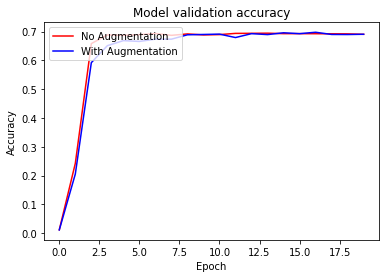

In [18]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

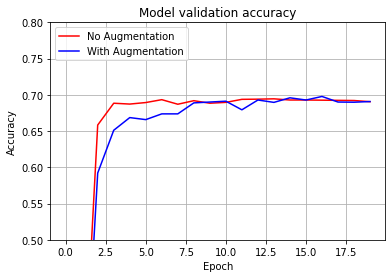

In [19]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.5, 0.8)  # 출력하고자 하는 Accuracy 범위를 지정.
plt.show()

* Augmentation을 적용하지 않은 데이터가 Augmentation을 적용한 데이터보다 더 빠르게 정확도가 수렴하고 있습니다.

## 5. Augmentation에 의한 모델 성능 비교

In [20]:
# CutMix, Mixup 모델 생성 및 데이터 가공
cutmix_resnet50 = model_gene()
mixup_resnet50 = model_gene()
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

In [21]:
# CutMix
history_resnet50_cutmix = train_gene(cutmix_resnet50, ds_train_aug_cutmix)

Epoch 1/20
375/375 [==============================] - 86s 208ms/step - loss: 4.1725 - accuracy: 0.1127 - val_loss: 5.5218 - val_accuracy: 0.0068
Epoch 2/20
375/375 [==============================] - 77s 205ms/step - loss: 3.0272 - accuracy: 0.3038 - val_loss: 4.0965 - val_accuracy: 0.2134
Epoch 3/20
375/375 [==============================] - 77s 205ms/step - loss: 2.4473 - accuracy: 0.4153 - val_loss: 1.8222 - val_accuracy: 0.5061
Epoch 4/20
375/375 [==============================] - 77s 205ms/step - loss: 2.0732 - accuracy: 0.4948 - val_loss: 1.7767 - val_accuracy: 0.5191
Epoch 5/20
375/375 [==============================] - 77s 205ms/step - loss: 1.7924 - accuracy: 0.5555 - val_loss: 1.5891 - val_accuracy: 0.5737
Epoch 6/20
375/375 [==============================] - 77s 205ms/step - loss: 1.5996 - accuracy: 0.6053 - val_loss: 1.6343 - val_accuracy: 0.5592
Epoch 7/20
375/375 [==============================] - 77s 205ms/step - loss: 1.4026 - accuracy: 0.6510 - val_loss: 1.6840 - val_ac

In [22]:
# Mixup
history_resnet50_mixup = train_gene(mixup_resnet50, ds_train_aug_mixup)

Epoch 1/20
375/375 [==============================] - 85s 207ms/step - loss: 4.1821 - accuracy: 0.1443 - val_loss: 5.0858 - val_accuracy: 0.0079
Epoch 2/20
375/375 [==============================] - 77s 205ms/step - loss: 3.1908 - accuracy: 0.3695 - val_loss: 3.2248 - val_accuracy: 0.2358
Epoch 3/20
375/375 [==============================] - 77s 205ms/step - loss: 2.8447 - accuracy: 0.4942 - val_loss: 1.7194 - val_accuracy: 0.5299
Epoch 4/20
375/375 [==============================] - 77s 205ms/step - loss: 2.6470 - accuracy: 0.5635 - val_loss: 1.5007 - val_accuracy: 0.5830
Epoch 5/20
375/375 [==============================] - 77s 206ms/step - loss: 2.4992 - accuracy: 0.6290 - val_loss: 1.4938 - val_accuracy: 0.5954
Epoch 6/20
375/375 [==============================] - 77s 206ms/step - loss: 2.3743 - accuracy: 0.6672 - val_loss: 1.7521 - val_accuracy: 0.5354
Epoch 7/20
375/375 [==============================] - 77s 205ms/step - loss: 2.2824 - accuracy: 0.7065 - val_loss: 1.4857 - val_ac

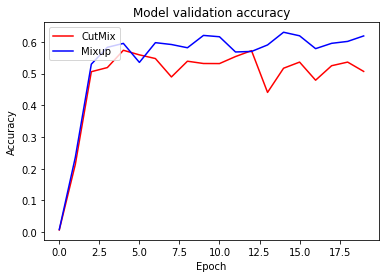

In [23]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CutMix', 'Mixup'], loc='upper left')
plt.show()

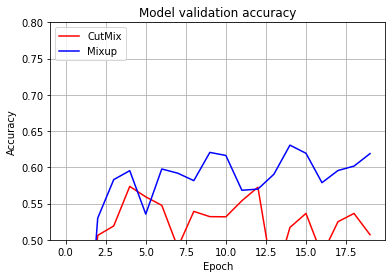

In [24]:
# 확대
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.5, 0.8)  # 출력하고자 하는 Accuracy 범위를 지정.
plt.show()

* CutMix를 적용한 데이터셋 보다 Mixup을 적용한 데이터셋의 정확도가 좀 더 높게 나왔습니다.

### 원본 데이터셋, 기본 Augmentation 적용 데이터셋, 기본 Aug + Cutmix 적용 데이터셋, 기본 Aug + Mixup 적용 데이터셋 비교 시각화

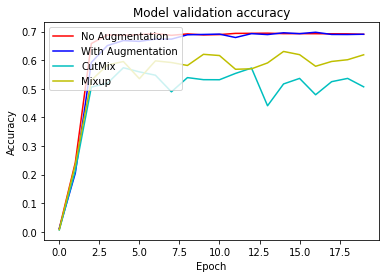

In [27]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

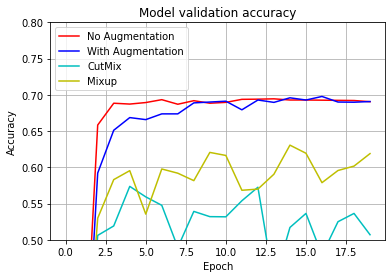

In [29]:
# 확대
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.5, 0.8)  # 출력하고자 하는 Accuracy 범위를 지정.
plt.show()

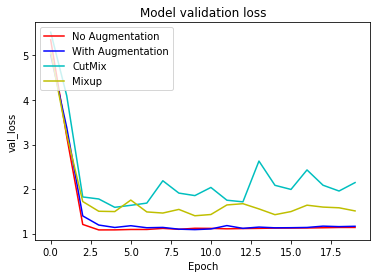

In [39]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'c')
plt.plot(history_resnet50_mixup.history['val_loss'], 'y')
plt.title('Model validation loss')
plt.ylabel('val_loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

* No Augmentation은 train 데이터셋에 변화를 주지 않아서 test 데이터셋과의 이미지들이 비슷한 형태라서 정확도가 높다고 생각했습니다.
* 그에 반에 With Augmentation은 원본 데이터셋에 밝기 변화와 좌우반전을 넣었고, 좌우반전은 큰 영향은 없을 것 같다고 생각하고, 밝기 변화에 따른 픽셀값이 조금이지만 한쪽으로 쏠리는(0이나 255에 가깝게) 형태로 변하기 때문에 특성이 연해져서 No Augmentation 보다 학습하는데 조금 더 시간이 들고 정확도의 값 좀 튀는 것 같습니다.
* Mixup 같은 경우 두개의 이미지가 섞여서 특성이 흐려져서 원본 데이터셋이나 테스트 데이터셋과는 조금 다른 유형의 이미지가 되어서 구분하는데 어려움이 생겨 With Augmentation 보다도 정확도가 떨어지는 것 같습니다.(원본 데이터셋이나 테스트 데이터셋은 깔끔한 이미지라면 Mixup 같은 경우는 이미지에 gaussian_noise를 추가한 것과 비슷하다고 생각합니다.)
* CutMix 같은 경우는 이미지에 일부분이 원본 이미지와의 전혀다른 특성을 가지고 있을 확률이 높거나, 합친 이미지가 배경같이 구분할만한 특성이 없는 이미지이면서 원본 이미지의 특성을 가리면 불 필요한 데이터가 되기도 해서, test 데이터셋 기준으로 볼 때 판별하는데 혼란이 오기 때문에 Mixup 보다 정확도가 떨어지는 것이라고 생각했습니다.

# 회고

* 본 프로젝트에서는 원본 이미지 데이터셋에 밝기변화, 좌우반전 등 여러 변화를 주어서 모델을 학습한 후, 주어진 변화에 따른 모델의 정확도를 측정해봅니다.
* 밝기 변화나 좌우 반전 같은 경우는 데이터셋 중 있을만한 변화정도라고 생각해서 정확도가 원본과 큰차이가 없었다고 생각하지만, 두 이미지를 반투명 상태로 합치거나 이미지의 일부분을 다른 이미지로 대체하는 방법들은 데이터가 많을 경우 일부 이런 변화를 준 데이터를 모델이 다양한 특성의 데이터를 학습하는 좋은 영향을 줄 수 있겠지만 데이터가 작다면 모델 학습에 좋지 못한 영향을 줄 수 있다는 것을 알게되었습니다.